In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import plotly.express as px
import mapclassify
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import time
import random
import matplotlib.pyplot as plt
from shapely import wkt
import scipy 
from scipy import stats 
from libpysal.weights import Queen, KNN
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pygeoda
from tabulate import tabulate
from esda.moran import Moran_BV, Moran_Local_BV
from splot.esda import plot_moran_bv_simulation, plot_moran_bv
import re

/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python

In [2]:
df_final = pd.read_csv(r"/Users/yuhan/Desktop/paper——revision/df_final.csv")
HMA_PMD_pth = r"/Users/yuhan/Desktop/paper——revision/HMA_PMD.csv"
PDMData = pd.read_csv( HMA_PMD_pth )

print( df_final.columns)
print( "programFy unique ", PDMData.Year.unique() )

Index(['Unnamed: 0', 'fips', 'Year', 'HMAprojAmot', 'NumProperty', 'NumHMA',
       'Hazard2', 'disasternumber_x', 'CropDmg', 'CropDmg21',
       'CropDmgPerCapita21', 'PropertyDmg', 'ProDmg21', 'ProDmgPerCapita21',
       'Injuries', 'InjuriesPerCapita', 'Fatalities', 'FatalitiesPerCapita',
       'Duration_Days', 'Count_h', 'ApprovLoan_h', 'Count_b', 'ApprovLoan_b',
       'HAODamage', 'HAOCount', 'HAOAproved', 'HAORepaRepl', 'HAORental',
       'HAOOther', 'HARCount', 'HARAproved', 'HARRepaRepl', 'HARRental',
       'HAROther', 'PAprojectAmt', 'PAfedshare', 'PAtotobl', 'NRI_ID', 'STATE',
       'STATEABBRV', 'COUNTY', 'COUNTYTYPE', 'STCOFIPS', 'POPULATION',
       'BUILDVALUE', 'AGRIVALUE', 'AREA', 'RISK_VALUE', 'RISK_SCORE',
       'RISK_RATNG', 'RISK_SPCTL', 'EAL_VALT', 'EAL_VALB', 'EAL_VALP',
       'EAL_VALPE', 'EAL_VALA', 'ALR_VALB', 'ALR_VALP', 'ALR_VALA',
       'ALR_NPCTL', 'SOVI_SCORE', 'SOVI_RATNG', 'SOVI_SPCTL', 'RESL_SCORE',
       'RESL_RATNG', 'RESL_SPCTL', 'RESL_VALUE

In [3]:
df_final.PropertyDmg = df_final.PropertyDmg.fillna(0)
df_final.PropertyDmg

0         100000.0
1        1300000.0
2        8623850.0
3         625000.0
4          43000.0
           ...    
92617       9000.0
92618        700.0
92619     583400.0
92620      23000.0
92621      53600.0
Name: PropertyDmg, Length: 92622, dtype: float64

In [4]:
print( "old ", df_final.shape )
df_final = df_final[~df_final["State Name"].isin(['HAWAII','ALASKA', 'AMERICAN SAMOA', 'GUAM', 'PUERTO RICO', 'VIRGIN ISLANDS',
                                       'COMMONWEALTH OF THE NORTHERN MARIANA ISLANDS'])]
print( "new ", df_final.shape )

old  (92622, 69)


KeyError: 'State Name'

In [5]:
PDMData.head()

,index,projectIdentifier,programArea,programFy,region,state,stateNumberCode,county,countyCode,disasterNumber,...,stateCode,FIPS,FIPS2,fyDeclared,disasterType,incidentType,duration,incidentdate,incidentdateplace,Year
0,1844,PDMC-PL-07-NE-2014-002,PDM,2014.0,7.0,Nebraska,31,Knox,107,0,...,31,31107,31107,NaN,NaN,NaN,NaN,NaN,NaN,2014.0
1,1845,PDMC-PJ-06-OK-2014-001,PDM,2014.0,6.0,Oklahoma,40,NaN,0,0,...,40,40000,40000,NaN,NaN,NaN,NaN,NaN,NaN,2014.0
2,1846,PDMC-PL-05-WI-2016-002,PDM,2016.0,5.0,Wisconsin,55,Florence,37,0,...,55,55037,55037,NaN,NaN,NaN,NaN,NaN,NaN,2016.0
3,1847,PDMC-PL-03-VA-2016-001,PDM,2016.0,3.0,Virginia,51,Waynesboro (city),820,0,...,51,51820,51820,NaN,NaN,NaN,NaN,NaN,NaN,2016.0
4,1848,PDMC-PJ-04-FL-2003-021,PDM,2003.0,4.0,Florida,12,Broward,11,0,...,12,12011,12011,NaN,NaN,NaN,NaN,NaN,NaN,2003.0


In [6]:

#print( HMAData["County FIPS"] )
PDMData['FIPS'] = PDMData['FIPS'].apply(str)

print("before ", PDMData.shape)
PDMData         = PDMData.loc[ PDMData['Year'] > 2000 ]
print("after", PDMData.shape)
PDMData['PDMcount'] = np.where( PDMData['projectAmount'] > 0, 1, 0)
PDMData_multiple    = PDMData.groupby(['FIPS', 'Year']).agg({
                    'projectAmount'                :  ['sum'], 
                    'federalShareObligated'                      :  ['count'], 
                    'numberOfFinalProperties'       :  ['sum']   }).reset_index()
print(PDMData_multiple.columns)
PDMData_multiple.columns = PDMData_multiple.columns.droplevel(1)
PDMData_multiple.columns = ['FIPS', 'Year', 'PDMprojAmot', 'PDMcount', 'PDMNumfinalProp']
print(PDMData_multiple.shape)
print(PDMData_multiple.head())

before  (3944, 44)
after (3800, 44)
MultiIndex([(                   'FIPS',      ''),
            (                   'Year',      ''),
            (          'projectAmount',   'sum'),
            (  'federalShareObligated', 'count'),
            ('numberOfFinalProperties',   'sum')],
           )
(2795, 5)
   FIPS    Year  PDMprojAmot  PDMcount  PDMNumfinalProp
0  1000  2003.0   1487767.00         2              0.0
1  1000  2007.0     55637.00         1              0.0
2  1000  2009.0     64663.46         1              0.0
3  1000  2010.0     66792.66         1              0.0
4  1000  2013.0     78906.00         1              0.0


In [7]:
df_final['fips'].replace('', np.nan, inplace=True)
df_final.dropna(subset=['fips'], inplace=True)
df_final['fips']            = df_final['fips'].astype(int)
PDMData_multiple['FIPS']    = PDMData_multiple['FIPS'].apply(str).astype(int)
print( df_final.STCOFIPS.nunique() )

data_filterall_pdm  = pd.merge( df_final, PDMData_multiple, 
                              left_on=['fips', 'Year'], right_on=['FIPS', 'Year'], how='left')

data_filterall_pdm  = data_filterall_pdm.fillna(0)
data_filterall_pdm  = data_filterall_pdm.loc[ data_filterall_pdm['Hazard2'] != 0 ]
print( "fips ", data_filterall_pdm.fips.nunique() )
print( data_filterall_pdm.shape )

3226
fips  3238
(92622, 73)


In [8]:
print( "Unique hazard ", data_filterall_pdm.Hazard2.unique() )
print( "*******************************************" )
print( data_filterall_pdm.columns )
print( "*******************************************" )
print( data_filterall_pdm.head() )
print( "*******************************************" )
print( data_filterall_pdm.Hazard2.unique() )

Unique hazard  ['Climatological' 'Meteorological' 'Hydrological' 'Geophysical']
*******************************************
Index(['Unnamed: 0', 'fips', 'Year', 'HMAprojAmot', 'NumProperty', 'NumHMA',
       'Hazard2', 'disasternumber_x', 'CropDmg', 'CropDmg21',
       'CropDmgPerCapita21', 'PropertyDmg', 'ProDmg21', 'ProDmgPerCapita21',
       'Injuries', 'InjuriesPerCapita', 'Fatalities', 'FatalitiesPerCapita',
       'Duration_Days', 'Count_h', 'ApprovLoan_h', 'Count_b', 'ApprovLoan_b',
       'HAODamage', 'HAOCount', 'HAOAproved', 'HAORepaRepl', 'HAORental',
       'HAOOther', 'HARCount', 'HARAproved', 'HARRepaRepl', 'HARRental',
       'HAROther', 'PAprojectAmt', 'PAfedshare', 'PAtotobl', 'NRI_ID', 'STATE',
       'STATEABBRV', 'COUNTY', 'COUNTYTYPE', 'STCOFIPS', 'POPULATION',
       'BUILDVALUE', 'AGRIVALUE', 'AREA', 'RISK_VALUE', 'RISK_SCORE',
       'RISK_RATNG', 'RISK_SPCTL', 'EAL_VALT', 'EAL_VALB', 'EAL_VALP',
       'EAL_VALPE', 'EAL_VALA', 'ALR_VALB', 'ALR_VALP', 'ALR_VALA'

In [9]:
data_filterall_pdm['declared'] = np.where( ( (data_filterall_pdm['disasternumber_x'] > 0)  ) , 1, 0)
data_filterall_pdm['declared'].unique()

array([0, 1])

In [10]:
data_filterall_pdm.head()

,Unnamed: 0,fips,Year,HMAprojAmot,NumProperty,NumHMA,Hazard2,disasternumber_x,CropDmg,CropDmg21,...,RESL_RATNG,RESL_SPCTL,RESL_VALUE,x,y,FIPS,PDMprojAmot,PDMcount,PDMNumfinalProp,declared
0,0,10001,2002.0,0.0,0.0,0.0,Climatological,0.0,0.0,0.0,...,Relatively High,0.666667,2.684585,2.073775e+06,-348155.917603,0.0,0.0,0.0,0.0,0
1,1,10001,2003.0,0.0,0.0,0.0,Climatological,0.0,0.0,0.0,...,Relatively High,0.666667,2.684585,2.073775e+06,-348155.917603,0.0,0.0,0.0,0.0,0
2,2,10001,2003.0,0.0,0.0,0.0,Meteorological,0.0,0.0,0.0,...,Relatively High,0.666667,2.684585,2.073775e+06,-348155.917603,0.0,0.0,0.0,0.0,0
3,3,10001,2004.0,0.0,0.0,0.0,Hydrological,0.0,0.0,0.0,...,Relatively High,0.666667,2.684585,2.073775e+06,-348155.917603,0.0,0.0,0.0,0.0,0
4,4,10001,2004.0,0.0,0.0,0.0,Meteorological,0.0,0.0,0.0,...,Relatively High,0.666667,2.684585,2.073775e+06,-348155.917603,0.0,0.0,0.0,0.0,0


In [11]:
data_filterall_pdm['HazardCount']   = 1

data_filterall_pdm['HMAcount']      = np.where( data_filterall_pdm['HMAprojAmot'] > 0, 1, 0)
data_filterall_pdm['HAtotal']       = data_filterall_pdm['HAOAproved'] + data_filterall_pdm['HARAproved']
data_filterall_pdm['HAcount']       = np.where( ( ( data_filterall_pdm['HAOCount'] > 0 ) | (data_filterall_pdm['HARCount'] > 0) ), 1, 0)
data_filterall_pdm['PAcount']       = np.where(  data_filterall_pdm['PAprojectAmt'] > 0, 1, 0)

data_filterall_pdm['SBAcount']      = data_filterall_pdm['Count_h'] + data_filterall_pdm['Count_b']
data_filterall_pdm['SBAapproved']   = data_filterall_pdm['ApprovLoan_h'] + data_filterall_pdm['ApprovLoan_b']
data_filterall_pdm['SBAProjcount']  = np.where( ( (data_filterall_pdm['Count_h'] > 0) | (data_filterall_pdm['Count_b'] > 0)), 1, 0)

In [12]:
data_county_hazard = data_filterall_pdm.groupby([ 'fips' , 'Hazard2'], as_index=False).agg({  
                                    'HMAprojAmot' :  ['sum'],   
                                    'NumProperty' :  ['sum'], 'NumHMA' :  ['sum'], 
                                    'CropDmg' :  ['sum'], 'CropDmg21' :  ['sum'], 
                                    'CropDmgPerCapita21' :  ['sum'],
                                    'PropertyDmg' :   ['sum' ],  
                                    'ProDmg21' :  ['sum'],
                                    'ProDmgPerCapita21' :  ['sum'],
                                    'Injuries' :  ['sum'], 'InjuriesPerCapita' :  ['sum'], 
                                    'Fatalities' :  ['sum'], 'FatalitiesPerCapita' :  ['sum'], 
                                    'Duration_Days' :  ['sum'],  'PAprojectAmt' :  ['sum'],                          
                                    'PDMprojAmot' :  ['sum'], 'PDMcount' :  ['sum'], 
                                    'PDMNumfinalProp' :  ['sum'], 'HMAcount' :  ['sum'], 'HAtotal' :  ['sum'],
                                    'HAcount' :  ['sum'], 'PAcount' :  ['sum'], 'SBAcount' :  ['sum'], 
                                    'SBAProjcount' :  ['sum'], 'SBAapproved' :  ['sum'],
                                    'HazardCount': ['sum'], 'x': ['mean'], 'y': ['mean']
                                    }).reset_index()
print( data_county_hazard.head() )
data_county_hazard.columns = data_county_hazard.columns.droplevel(1)

  index  fips         Hazard2   HMAprojAmot NumProperty NumHMA   CropDmg  \
                                        sum         sum    sum       sum   
0     0  1001  Climatological  6.753450e+05        98.0    6.0       0.0   
1     1  1001    Hydrological  1.191964e+06       106.0   10.0       0.0   
2     2  1001  Meteorological  1.535674e+06       167.0   15.0  150000.0   
3     3  1003  Climatological  2.134794e+08       110.0  182.0       0.0   
4     4  1003    Hydrological  2.273364e+08       127.0  216.0       0.0   

   CropDmg21 CropDmgPerCapita21  PropertyDmg  ... HMAcount       HAtotal  \
         sum                sum          sum  ...      sum           sum   
0       0.00            0.00000    2694000.0  ...        3  1.871322e+06   
1       0.00            0.00000    1702000.0  ...        5  3.890625e+06   
2  189564.01            3.86349   18428100.0  ...        8  7.687544e+06   
3       0.00            0.00000     114000.0  ...       25  2.428607e+09   
4       0.0

In [43]:
data_county_hazard.shape

(9800, 31)

In [13]:

declared_county_hazard = data_filterall_pdm.loc[ data_filterall_pdm['declared'] > 0 ].groupby([ 'fips', 'Hazard2'], as_index=False).agg({  
                                    'HMAprojAmot' :  ['sum'],   
                                    'NumProperty' :  ['sum'], 'NumHMA' :  ['sum'], 
                                    'CropDmg' :  ['sum'], 'CropDmg21' :  ['sum'], 
                                    'CropDmgPerCapita21' :  ['sum'],
                                    'PropertyDmg' :   ['sum' ],  
                                    'ProDmg21' :  ['sum'],
                                    'ProDmgPerCapita21' :  ['sum'],
                                    'Injuries' :  ['sum'], 'InjuriesPerCapita' :  ['sum'], 
                                    'Fatalities' :  ['sum'], 'FatalitiesPerCapita' :  ['sum'], 
                                    'Duration_Days' :  ['sum'],  'PAprojectAmt' :  ['sum'],                          
                                    'PDMprojAmot' :  ['sum'], 'PDMcount' :  ['sum'], 
                                    'PDMNumfinalProp' :  ['sum'], 'HMAcount' :  ['sum'], 'HAtotal' :  ['sum'],
                                    'HAcount' :  ['sum'], 'PAcount' :  ['sum'], 'SBAcount' :  ['sum'], 
                                    'SBAProjcount' :  ['sum'], 'SBAapproved' :  ['sum'],
                                    'HazardCount': ['sum'], 'x': ['mean'], 'y': ['mean']
                                    }).reset_index()

declared_county_hazard.columns = declared_county_hazard.columns.droplevel(1)
print( declared_county_hazard.head() )

   index  fips         Hazard2   HMAprojAmot  NumProperty  NumHMA   CropDmg  \
0      0  1001  Climatological  6.753450e+05         98.0     6.0       0.0   
1      1  1001    Hydrological  1.191964e+06        106.0    10.0       0.0   
2      2  1001  Meteorological  1.535674e+06        167.0    15.0  100000.0   
3      3  1003  Climatological  2.134794e+08        110.0   182.0       0.0   
4      4  1003    Hydrological  2.273364e+08        127.0   216.0       0.0   

   CropDmg21  CropDmgPerCapita21  PropertyDmg  ...  HMAcount       HAtotal  \
0       0.00             0.00000    2690000.0  ...         3  1.871322e+06   
1       0.00             0.00000    1702000.0  ...         5  3.890625e+06   
2  139351.32             2.96915   18306100.0  ...         8  7.687544e+06   
3       0.00             0.00000     101000.0  ...        25  2.428607e+09   
4       0.00             0.00000  125354000.0  ...        35  2.575731e+09   

   HAcount  PAcount  SBAcount  SBAProjcount  SBAapproved

In [14]:
socialattr_pth = r"/Users/yuhan/Desktop/paper——revision/FLCounty_JEPR/ACS_County_2000_2019_JPER/National Risk Index/NRI_Shapefile_Counties/NRI_Shapefile_Counties.shp"
#socialattrreader = pd.read_csv( socialattr_pth )
socialattrreader = gpd.read_file( socialattr_pth )
################################################################################################
cbsa_fips_pth = r"/Users/yuhan/Desktop/paper——revision/ACS_County_level_UC/County_US_cbsa2.shp"
cbsafipsreader = gpd.read_file( cbsa_fips_pth )
################################################################################################
print( socialattrreader.crs )
print( cbsafipsreader.crs )

EPSG:3857
EPSG:3857


In [15]:
socialattrreader    = socialattrreader.to_crs({'init':'epsg:4326'})
cbsafipsreader      = cbsafipsreader.to_crs({'init':'epsg:4326'})

/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [16]:
socialattrreader.bounds.max()

minx    145.689561
miny     67.999953
maxx    179.778439
maxy     71.361281
dtype: float64

In [17]:
print(socialattrreader.shape)
socialattrreader2 = socialattrreader[~socialattrreader.STATEABBRV.isin([
                                    'HI','AK', 'AS', 'GU', 'PR', 'VI','MP'])]
print(socialattrreader2.shape)
print( socialattrreader2.columns )

(3231, 467)
(3108, 467)
Index(['NRI_ID', 'STATE', 'STATEABBRV', 'STATEFIPS', 'COUNTY', 'COUNTYTYPE',
       'COUNTYFIPS', 'STCOFIPS', 'POPULATION', 'BUILDVALUE',
       ...
       'WNTW_ALRP', 'WNTW_ALRA', 'WNTW_ALR_N', 'WNTW_RISKV', 'WNTW_RISKS',
       'WNTW_RISKR', 'NRI_VER', 'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object', length=467)


In [18]:
cbsafipsreader2 = cbsafipsreader[ [ "STCOFIPS", "NAME" ] ]
cbsafipsreader2["name2"] = cbsafipsreader2["NAME"].str.split("-")[0]
print( cbsafipsreader2.name2.unique() )
#data_county_hazard

[nan]


/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_105/3650769886.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cbsafipsreader2["name2"] = cbsafipsreader2["NAME"].str.split("-")[0]


In [19]:
social_df = pd.merge( socialattrreader2, cbsafipsreader2, left_on=['STCOFIPS'], right_on=['STCOFIPS'], how='left')

In [20]:
print( social_df["STCOFIPS"].unique() )
print( social_df.columns )
social_df['fips'] = pd.to_numeric( social_df[ 'STCOFIPS' ].apply(str) )
print( social_df["fips"].unique() )

['01001' '01003' '01005' ... '56041' '56043' '56045']
Index(['NRI_ID', 'STATE', 'STATEABBRV', 'STATEFIPS', 'COUNTY', 'COUNTYTYPE',
       'COUNTYFIPS', 'STCOFIPS', 'POPULATION', 'BUILDVALUE',
       ...
       'WNTW_ALR_N', 'WNTW_RISKV', 'WNTW_RISKS', 'WNTW_RISKR', 'NRI_VER',
       'Shape_Leng', 'Shape_Area', 'geometry', 'NAME', 'name2'],
      dtype='object', length=469)
[ 1001  1003  1005 ... 56041 56043 56045]


In [21]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
print( social_df.columns )
social_df.SOVI_SCORE

Index(['NRI_ID', 'STATE', 'STATEABBRV', 'STATEFIPS', 'COUNTY', 'COUNTYTYPE', 'COUNTYFIPS', 'STCOFIPS', 'POPULATION', 'BUILDVALUE',
       ...
       'WNTW_RISKV', 'WNTW_RISKS', 'WNTW_RISKR', 'NRI_VER', 'Shape_Leng', 'Shape_Area', 'geometry', 'NAME', 'name2', 'fips'], dtype='object', length=470)


0       51.299999
1       31.030001
2       99.269997
3       80.779999
4       51.369999
          ...    
3103    37.400002
3104    19.190001
3105    40.639999
3106    26.610001
3107    23.200001
Name: SOVI_SCORE, Length: 3108, dtype: float64

In [22]:
print( data_county_hazard.fips.unique() )
print( data_county_hazard.columns )
print( data_county_hazard.Hazard2.unique() )


[ 1001  1003  1005 ... 78010 78020 78030]
Index(['index', 'fips', 'Hazard2', 'HMAprojAmot', 'NumProperty', 'NumHMA', 'CropDmg', 'CropDmg21', 'CropDmgPerCapita21', 'PropertyDmg', 'ProDmg21', 'ProDmgPerCapita21', 'Injuries', 'InjuriesPerCapita', 'Fatalities', 'FatalitiesPerCapita', 'Duration_Days', 'PAprojectAmt', 'PDMprojAmot', 'PDMcount', 'PDMNumfinalProp', 'HMAcount', 'HAtotal', 'HAcount', 'PAcount', 'SBAcount', 'SBAProjcount', 'SBAapproved', 'HazardCount', 'x', 'y'], dtype='object')
['Climatological' 'Hydrological' 'Meteorological' 'Geophysical']


In [23]:
print( data_county_hazard.loc[ data_county_hazard['Hazard2'] == 'Climatological'  ].PropertyDmg.shape,
data_county_hazard.loc[ data_county_hazard['Hazard2'] == 'Hydrological'  ].PropertyDmg.shape,
data_county_hazard.loc[ data_county_hazard['Hazard2'] == 'Meteorological'  ].PropertyDmg.shape,
data_county_hazard.loc[ data_county_hazard['Hazard2'] == 'Geophysical'  ].PropertyDmg.shape )

(2994,) (3073,) (3208,) (525,)


In [24]:
social_df = social_df[[ 'STATE', 'STATEABBRV', 'STATEFIPS', 'COUNTY', 
                        'STCOFIPS', 'POPULATION', 'BUILDVALUE', 'SOVI_SCORE', 
                        'NAME', 'fips', 'geometry']]

In [25]:
print( "*************************************" )
print( social_df.shape)
print( "*************************************" )
print( data_county_hazard.shape)
print( "*************************************" )
print( data_county_hazard.columns)

*************************************
(3108, 11)
*************************************
(9800, 31)
*************************************
Index(['index', 'fips', 'Hazard2', 'HMAprojAmot', 'NumProperty', 'NumHMA', 'CropDmg', 'CropDmg21', 'CropDmgPerCapita21', 'PropertyDmg', 'ProDmg21', 'ProDmgPerCapita21', 'Injuries', 'InjuriesPerCapita', 'Fatalities', 'FatalitiesPerCapita', 'Duration_Days', 'PAprojectAmt', 'PDMprojAmot', 'PDMcount', 'PDMNumfinalProp', 'HMAcount', 'HAtotal', 'HAcount', 'PAcount', 'SBAcount', 'SBAProjcount', 'SBAapproved', 'HazardCount', 'x', 'y'], dtype='object')


In [26]:
data_county_hazard['totalAssist']   = data_county_hazard['HMAprojAmot']  + data_county_hazard['PAprojectAmt'] + data_county_hazard['PDMprojAmot'] + data_county_hazard['HAtotal'] + data_county_hazard['SBAapproved'] 
data_county_hazard['totalAssist3']  = data_county_hazard['HMAprojAmot']  + data_county_hazard['PAprojectAmt'] + data_county_hazard['PDMprojAmot'] + data_county_hazard['HAtotal']
data_county_hazard['totalDamage']   = data_county_hazard['CropDmg']     + data_county_hazard['PropertyDmg'] 

data_county_hazard['logDamage']     = np.log( data_county_hazard['totalDamage'] + 1 )
data_county_hazard['logHMAAmot']    = np.log( data_county_hazard['HMAprojAmot'] + 1 )
data_county_hazard['logPAAmot']     = np.log( data_county_hazard['PAprojectAmt'] + 1 )

data_county_hazard['logPDMAmot']    = np.log( data_county_hazard['PDMprojAmot'] + 1 )
data_county_hazard['logHAAmot']     = np.log( data_county_hazard['HAtotal'] + 1 )
data_county_hazard['logSBAAmot']    = np.log( data_county_hazard['SBAapproved'] + 1 )

In [27]:
def classifyHazard( x ):
    if x in [ 'Landslide',  'Earthquake', 'Volcano', 'Avalanche', 'Tsunami']:
        return 'Geophysical'
    elif x in [ 'Flooding',  'Coastal']:
        return 'Hydrological'
    elif x in [ 'Hurricane',  'Tornado',  'Lightning',  'Severe Storm',  'Fog', 'Hail']:
        return 'Meteorological'
    elif x in [ 'Heat',  'Winter Weather', 'Wind', 'Wildfire',  'Drought']:
        return 'Climatological'
    else:
        return 'Other'
    
#data_county_hazard['HazardCate'] = data_county_hazard.apply(lambda x: classifyHazard( x['Hazard'] ), axis=1)
data_county_hazard['HazardCate'] = data_county_hazard['Hazard2']

In [28]:
print( data_county_hazard['HazardCate'].unique() )
print( data_county_hazard.shape )

['Climatological' 'Hydrological' 'Meteorological' 'Geophysical']
(9800, 41)


In [30]:
hazards_all = data_county_hazard.HazardCate.unique()
for hazardi in hazards_all:
    dfjoin_hazardi = data_county_hazard.loc[ data_county_hazard['HazardCate'] == hazardi ].reset_index()
    #print( "Hazard i shape is ", dfjoin_hazardi.shape )
    df_joini = pd.merge( social_df, dfjoin_hazardi, 
                    left_on=['fips'], right_on=['fips'], how='left' )
    df_joini = df_joini.fillna(0)

    guerry  = pygeoda.open( df_joini )
    queen_w = pygeoda.queen_weights( guerry )
    data11  = guerry['logDamage']
    data12  = guerry['SOVI_SCORE']
    data1   = guerry['logHMAAmot']
    data3   = guerry['logPAAmot']
    data5   = guerry['logPDMAmot']
    data4   = guerry['logHAAmot']
    data2   = guerry['logSBAAmot']
    
    nm1 = pygeoda.local_bimoran(queen_w, data11, data1)
    nm2 = pygeoda.local_bimoran(queen_w, data11, data2)
    nm3 = pygeoda.local_bimoran(queen_w, data11, data3)
    nm4 = pygeoda.local_bimoran(queen_w, data11, data4)
    nm5 = pygeoda.local_bimoran(queen_w, data11, data5)
    
    nm1_2 = pygeoda.local_bimoran(queen_w, data12, data1)
    nm2_2 = pygeoda.local_bimoran(queen_w, data12, data2)
    nm3_2 = pygeoda.local_bimoran(queen_w, data12, data3)
    nm4_2 = pygeoda.local_bimoran(queen_w, data12, data4)
    nm5_2 = pygeoda.local_bimoran(queen_w, data12, data5)

    nm1_3 = pygeoda.local_bimoran(queen_w, data11, data12)
    
    df_joini["csovi1"]          = list( nm1_2.lisa_clusters() )
    df_joini["csovi2"]          = list( nm2_2.lisa_clusters() )
    df_joini["csovi3"]          = list( nm3_2.lisa_clusters() )
    df_joini["csovi4"]          = list( nm4_2.lisa_clusters() )
    df_joini["csovi5"]          = list( nm5_2.lisa_clusters() )

    df_joini["cdamag1"]         = list( nm1.lisa_clusters() )
    df_joini["cdamag2"]         = list( nm2.lisa_clusters() )
    df_joini["cdamag3"]         = list( nm3.lisa_clusters() )
    df_joini["cdamag4"]         = list( nm4.lisa_clusters() )
    df_joini["cdamag5"]         = list( nm5.lisa_clusters() )

    df_joini["cdamsovi1"]       = list( nm1_3.lisa_clusters() )


    hazardi = hazardi.split("/")[0]
    #re.sub( r'/', '_', hazardi)
    if hazardi.isspace():
        hazardi = hazardi.replace(" ", "_")
    print("Hazard ", hazardi , " is ",  )
    state_pthi = r"/Users/yuhan/Desktop/paper——revision/Dataprocess/jupitor/hazard_shp/states_sheldus_" + str(hazardi) + r".shp"
    df_joini = gpd.GeoDataFrame( df_joini , geometry = 'geometry', crs="EPSG:4326")
    df_joini.to_file( state_pthi ,driver='ESRI Shapefile')

Hazard  Climatological  is 


/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_105/3669415911.py:56: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df_joini.to_file( state_pthi ,driver='ESRI Shapefile')


Hazard  Hydrological  is 


/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_105/3669415911.py:56: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df_joini.to_file( state_pthi ,driver='ESRI Shapefile')


Hazard  Meteorological  is 


/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_105/3669415911.py:56: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df_joini.to_file( state_pthi ,driver='ESRI Shapefile')


Hazard  Geophysical  is 


/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_105/3669415911.py:56: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df_joini.to_file( state_pthi ,driver='ESRI Shapefile')


In [38]:
df_joini.head()

,STATE,STATEABBRV,STATEFIPS,COUNTY,STCOFIPS,POPULATION,BUILDVALUE,SOVI_SCORE,NAME,fips,geometry,level_0,index,Hazard2,HMAprojAmot,AdminCostAmt,NumfinalProp,CropDmg,CropDmg(ADJ 2021),CropDmgPerCapita(ADJ 2021),PropertyDmg,PropertyDmg(ADJ 2021),PropertyDmgPerCapita(ADJ 2021),Injuries,InjuriesPerCapita,Fatalities,FatalitiesPerCapita,Duration_Days,PAprojectAmt,PDMprojAmot,PDMcount,PDMNumfinalProp,HMAcount,HAtotal,HAcount,PAcount,SBAcount,SBAProjcount,SBAapproved,HazardCount,x,y,totalAssist,totalAssist3,totalDamage,logDamage,logHMAAmot,logPAAmot,logPDMAmot,logHAAmot,logSBAAmot,HazardCate
0,Alabama,AL,01,Autauga,01001,58764,9.123274e+09,51.299999,"Montgomery, AL",1001,"POLYGON ((-86.41284 32.63589, -86.41279 32.625...",0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,Alabama,AL,01,Baldwin,01003,231365,4.596848e+10,31.030001,"Daphne-Fairhope-Foley, AL",1003,"MULTIPOLYGON (((-87.92666 30.66002, -87.92688 ...",0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,Alabama,AL,01,Barbour,01005,25160,4.847697e+09,99.269997,"Eufaula, AL-GA",1005,"POLYGON ((-85.25954 32.13837, -85.25882 32.138...",0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,Alabama,AL,01,Bibb,01007,22239,3.146947e+09,80.779999,"Birmingham-Hoover, AL",1007,"POLYGON ((-87.02581 33.21717, -87.02573 33.209...",0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,Alabama,AL,01,Blount,01009,58992,7.815620e+09,51.369999,"Birmingham-Hoover, AL",1009,"POLYGON ((-86.44414 34.25913, -86.44434 34.256...",0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [61]:

print( nm1_2.lisa_labels() )
print( np.unique( nm1_2.lisa_clusters() ) )
print( nm2_2.lisa_colors() )

('Not significant', 'High-High', 'Low-Low', 'Low-High', 'High-Low', 'Undefined', 'Isolated')
[0 1 2 3 4 6]
('#eeeeee', '#FF0000', '#0000FF', '#a7adf9', '#f4ada8', '#464646', '#999999')


In [62]:

data_list1 = []
data_list2 = []
hazards_all = data_county_hazard.HazardCate.unique()
for hazardi in hazards_all:
    dfjoin_hazardi = data_county_hazard.loc[ data_county_hazard['HazardCate'] == hazardi ].reset_index()
    #print( "Hazard i shape is ", dfjoin_hazardi.shape )
    df_joini = pd.merge( social_df, dfjoin_hazardi, 
                    left_on=['fips'], right_on=['fips'], how='left' )
    df_joini = df_joini.fillna(0)
    #print( "joined Hazard i df shape is ", df_joini.shape )
    x1         = df_joini['logDamage']
    x2         = df_joini['SOVI_SCORE']
    ylagged1   = df_joini['logHMAAmot']
    ylagged2   = df_joini['logPAAmot']
    ylagged3   = df_joini['logPDMAmot']
    ylagged4   = df_joini['logHAAmot']
    ylagged5   = df_joini['logSBAAmot']

    w = Queen.from_dataframe( df_joini )
    w.transform = 'r'

    moran_bv11 = Moran_BV(x1, ylagged1, w)
    moran_bv12 = Moran_BV(x1, ylagged2, w)
    moran_bv13 = Moran_BV(x1, ylagged3, w)
    moran_bv14 = Moran_BV(x1, ylagged4, w)
    moran_bv15 = Moran_BV(x1, ylagged5, w)
    moran_bv21 = Moran_BV(x2, ylagged1, w)
    moran_bv22 = Moran_BV(x2, ylagged2, w)
    moran_bv23 = Moran_BV(x2, ylagged3, w)
    moran_bv24 = Moran_BV(x2, ylagged3, w)
    moran_bv25 = Moran_BV(x2, ylagged5, w)

    print("Hazard ", hazardi , " is ",  )
    datai1 = {  "Hazard": hazardi,
                "HMAprojAmot": moran_bv11.I ,
                "PAprojectAmt": moran_bv12.I ,
                "PDMprojAmot": moran_bv13.I ,
                "HAtotal": moran_bv14.I ,
                "SBAapproved": moran_bv15.I 
    }
    datai2 = {  "Hazard": hazardi,
                "HMAprojAmot": moran_bv21.I ,
                "PAprojectAmt": moran_bv22.I ,
                "PDMprojAmot": moran_bv23.I ,
                "HAtotal": moran_bv24.I ,
                "SBAapproved": moran_bv25.I
    }
    data_list1.append( datai1 )
    data_list2.append( datai2 )
Morandf1 = pd.DataFrame( data_list1 )
Morandf1 = Morandf1.fillna(0)
Morandf2 = pd.DataFrame( data_list2 )
Morandf2 = Morandf2.fillna(0)

Morandf1.to_csv(r"/Users/yuhan/Desktop/paper——revision/Dataprocess/jupitor/Moran_Assist_Hazard1.csv", index=False)
Morandf2.to_csv(r"/Users/yuhan/Desktop/paper——revision/Dataprocess/jupitor/Moran_Assist_Hazard2.csv", index=False)

/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
 There are 4 islands with ids: 1186, 1192, 1836, 2946.
  warnings.warn(message)


('WARNING: ', 1186, ' is an island (no neighbors)')
('WARNING: ', 1192, ' is an island (no neighbors)')
('WARNING: ', 1836, ' is an island (no neighbors)')
('WARNING: ', 2946, ' is an island (no neighbors)')
Hazard  Climatological  is 


/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
 There are 4 islands with ids: 1186, 1192, 1836, 2946.
  warnings.warn(message)


('WARNING: ', 1186, ' is an island (no neighbors)')
('WARNING: ', 1192, ' is an island (no neighbors)')
('WARNING: ', 1836, ' is an island (no neighbors)')
('WARNING: ', 2946, ' is an island (no neighbors)')
Hazard  Hydrological  is 


/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
 There are 4 islands with ids: 1186, 1192, 1836, 2946.
  warnings.warn(message)


('WARNING: ', 1186, ' is an island (no neighbors)')
('WARNING: ', 1192, ' is an island (no neighbors)')
('WARNING: ', 1836, ' is an island (no neighbors)')
('WARNING: ', 2946, ' is an island (no neighbors)')
Hazard  Meteorological  is 


/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
 There are 4 islands with ids: 1186, 1192, 1836, 2946.
  warnings.warn(message)


('WARNING: ', 1186, ' is an island (no neighbors)')
('WARNING: ', 1192, ' is an island (no neighbors)')
('WARNING: ', 1836, ' is an island (no neighbors)')
('WARNING: ', 2946, ' is an island (no neighbors)')
Hazard  Geophysical  is 


In [151]:
print( moran_bv15.I )
print( Morandf1.columns )
print( Morandf1.Hazard.to_list() )
print( len( Morandf1.Hazard.to_list() ) )



0.2672315078892524
Index(['Hazard', 'HMAprojAmot', 'PAprojectAmt', 'PDMprojAmot', 'HAtotal', 'SBAapproved'], dtype='object')
['Climatological', 'Hydrological', 'Meteorological', 'Geophysical']
4


In [4]:


Morandf1 = pd.read_csv(r"/Users/yuhan/Desktop/paper——revision/Dataprocess/jupitor/Moran_Assist_Hazard1.csv" )
Morandf2 = pd.read_csv(r"/Users/yuhan/Desktop/paper——revision/Dataprocess/jupitor/Moran_Assist_Hazard2.csv" )

In [5]:
Morandf1

,Hazard,HMAprojAmot,PAprojectAmt,PDMprojAmot,HAtotal,SBAapproved
0,Climatological,0.217448,0.129601,0.139254,0.173512,0.167767
1,Hydrological,0.290834,0.122157,0.166951,0.318761,0.314292
2,Meteorological,0.337785,0.141795,0.100620,0.352012,0.346505
3,Geophysical,0.374037,0.045194,0.328858,0.247357,0.272223


In [6]:
Morandf2

,Hazard,HMAprojAmot,PAprojectAmt,PDMprojAmot,HAtotal,SBAapproved
0,Climatological,0.026430,0.064946,-0.053797,-0.053797,0.047274
1,Hydrological,0.012402,0.045979,-0.045609,-0.045609,0.024498
2,Meteorological,0.094370,0.089349,-0.062316,-0.062316,0.085563
3,Geophysical,-0.000971,0.002156,-0.019520,-0.019520,0.005082


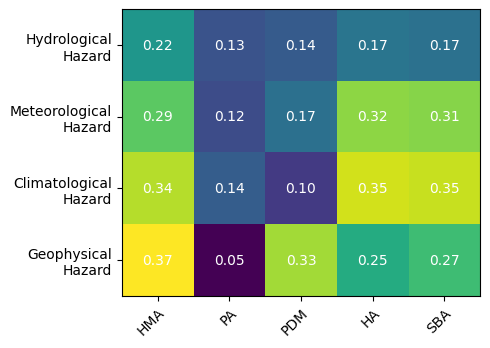

In [8]:


arr =  Morandf1[ ['HMAprojAmot', 'PAprojectAmt', 'PDMprojAmot', 'HAtotal', 'SBAapproved'] ].to_numpy()
labels = ['HMA', 
          'PA', 'PDM', 
          'HA', 'SBA']
rowlabels = ['Hydrological\nHazard', 'Meteorological\nHazard', 
             'Climatological\nHazard', 'Geophysical\nHazard']
fig, ax = plt.subplots( figsize=(5, 5) )
im = ax.imshow( arr )

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(labels)), labels= labels)
ax.set_yticks(np.arange(len(rowlabels)), labels= rowlabels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(rowlabels)):
    for j in range(len(labels)):
        text = ax.text(j, i, '%.2f' %arr[i, j],
                       ha="center", va="center", color="w")

#ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.savefig('DamagMoran.png', format = 'png', dpi=1200)





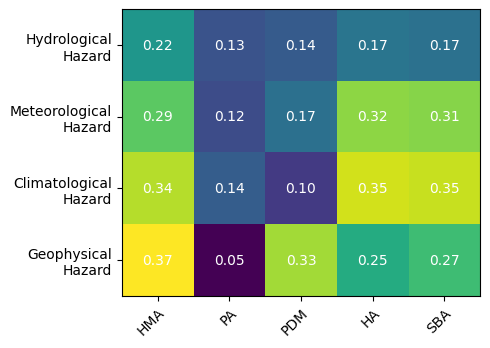

In [9]:
arr2 =  Morandf1[ ['HMAprojAmot', 'PAprojectAmt', 'PDMprojAmot', 'HAtotal', 'SBAapproved'] ].to_numpy()
labels2 = ['HMA', 'PA', 'PDM', 'HA', 'SBA']
rowlabels2 = ['Hydrological', 'Meteorological', 'Climatological', 'Geophysical']
fig, ax = plt.subplots( figsize=(5, 5) )
im = ax.imshow( arr2 )

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len( labels2 )), labels= labels)
ax.set_yticks(np.arange(len( rowlabels2 )), labels= rowlabels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len( rowlabels2 )):
    for j in range(len( labels2 )):
        text = ax.text(j, i, '%.2f' %arr2[i, j],
                       ha="center", va="center", color="w")

#ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.savefig('SOVIMoran.png', format = 'png', dpi=1200)
